In [1]:
# import dask.config as dc
import dask.array as da
import numpy as np
import rioxarray
import xarray as xr
import glob

from dask.distributed import Client, LocalCluster
from dask_jobqueue import SLURMCluster

# LAI data: from NetCDF to Zarr

The Leaf Area Index (LAI) dataset is provided as chunked NetCDF4/HDF5 data. We reproject the spatial extend to match the ERA5 land dataset using rioxarray, which, unfortunately does not support Dask. It is global.

## Input variables

In [33]:
year = [2014,2015]

In [37]:
ROOT_DIR = '/gpfs/work2/0/ttse0619'
LAI_DIR = (
    f'{ROOT_DIR}/qianqian/global_data_Qianqian/'
    f'1input_data/{year}global/lai/'
)
OUT_DIR = (
    f'{ROOT_DIR}/qianqian/global_data_Qianqian/'
    f'1input_data/{year[-1]}global/lai' #put the result of 2014 and 2015 in 2015 folder
)

In [38]:
#multiple years
LAI_DIR = []
for i in year:
    LAI_DIR0 = (
        f'{ROOT_DIR}/qianqian/global_data_Qianqian/'
        f'1input_data/{i}global/lai/'
    )
    LAI_DIR.append(LAI_DIR0)

In [39]:
LAI_DIR

['/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/1input_data/2014global/lai/',
 '/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/1input_data/2015global/lai/']

In [40]:
ERA5_PATH = (
    f'{ROOT_DIR}/francesco/Projects/EcoExtreML/Data/'
    f'1input_data/{year[-1]}global/era5land/era5land.zarr'
)

## Setup Dask cluster

NOTE: when working with NetCDF files (and the netcdf4 library) it is much better to work with many processes and few threads per process: netcdf4 can only read from one thread per process.

In [93]:
# cluster = LocalCluster(n_workers=4, threads_per_worker=1)

In [94]:
cluster = SLURMCluster(
    name='dask-worker',
    cores=16,
    processes=16,
    queue='fat',
    memory='120GiB',
    local_directory='$TMPDIR',
    walltime='1:00:00'
)

/home/qiahan/.conda/envs/mamba/envs/emulator/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43095 instead
  warnings.warn(


In [88]:
cluster.scale(jobs=4)

In [89]:
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/33165/status,
Dashboard: /proxy/33165/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://145.136.63.4:44965,Workers: 0
Dashboard: /proxy/33165/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Converting the dataset

We start by loading the ERA5-land Zarr dataset, which we will use as the target for reprojection: 

In [41]:
ds = xr.open_zarr(ERA5_PATH)

In [42]:
ds = ds.rio.write_crs('WGS84')
target = ds['sp'].isel(time=0, drop=True)

In [43]:
LAI_DIR

['/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/1input_data/2014global/lai/',
 '/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/1input_data/2015global/lai/']

We now open the LAI NetCDF files. NOTE: we do not set chunks in the spatial dimension because we need to load all values anyway to perform the reprojection. 

In [45]:
lai_paths = []
for i in LAI_DIR:
    lai_path = sorted(
        glob.glob(f'{i}/c_gls_LAI_*_GLOBE_*.nc')
    )
    print(lai_path)
    lai_paths.extend(lai_path)

['/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/1input_data/2014global/lai/c_gls_LAI_201401030000_GLOBE_VGT_V1.4.1.nc', '/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/1input_data/2014global/lai/c_gls_LAI_201401130000_GLOBE_VGT_V1.4.1.nc', '/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/1input_data/2014global/lai/c_gls_LAI_201401240000_GLOBE_VGT_V1.4.1.nc', '/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/1input_data/2014global/lai/c_gls_LAI_201402030000_GLOBE_VGT_V1.4.1.nc', '/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/1input_data/2014global/lai/c_gls_LAI_201402130000_GLOBE_VGT_V1.4.1.nc', '/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/1input_data/2014global/lai/c_gls_LAI_201402210000_GLOBE_VGT_V1.4.1.nc', '/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/1input_data/2014global/lai/c_gls_LAI_201403030000_GLOBE_VGT_V1.4.1.nc', '/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/1input_data/2014global/lai/c_gls_LAI_201403130000_GLOBE_VGT_V1.

In [16]:
# lai_paths = sorted(
#         glob.glob(f'{LAI_DIR}/c_gls_LAI_*0103*_GLOBE_*.nc')
#     )

In [47]:
lai = xr.open_mfdataset(lai_paths, chunks={})
lai = lai['LAI']  # keep only one variable
lai.rio.write_nodata(np.nan, inplace=True)

<xarray.DataArray 'LAI' (time: 72, lat: 15680, lon: 40320)>
dask.array<concatenate, shape=(72, 15680, 40320), dtype=float32, chunksize=(1, 15680, 40320), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * lat      (lat) float64 80.0 79.99 79.98 79.97 ... -59.97 -59.98 -59.99
  * time     (time) datetime64[ns] 2014-01-03 2014-01-13 ... 2015-12-24
Attributes:
    valid_range:    [  0 210]
    flag_values:    [253 254]
    grid_mapping:   crs
    flag_meanings:  Out_of_range_superior_to_physical_max Out_of_range_inferi...
    long_name:      Leaf Area Index 1km
    standard_name:  leaf_area_index
    units:          
    _FillValue:     nan

In [48]:
lai

<xarray.DataArray 'LAI' (time: 72, lat: 15680, lon: 40320)>
dask.array<concatenate, shape=(72, 15680, 40320), dtype=float32, chunksize=(1, 15680, 40320), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * lat      (lat) float64 80.0 79.99 79.98 79.97 ... -59.97 -59.98 -59.99
  * time     (time) datetime64[ns] 2014-01-03 2014-01-13 ... 2015-12-24
Attributes:
    valid_range:    [  0 210]
    flag_values:    [253 254]
    grid_mapping:   crs
    flag_meanings:  Out_of_range_superior_to_physical_max Out_of_range_inferi...
    long_name:      Leaf Area Index 1km
    standard_name:  leaf_area_index
    units:          
    _FillValue:     nan

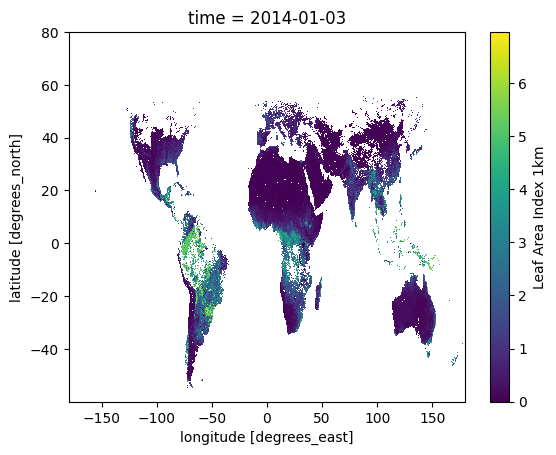

In [22]:
lai[0,:].plot()

We fix the longitude ordering and make sure the CRS is in place:

In [23]:
lai = lai.rio.write_crs('WGS84')
lai = lai.rename(
    lon='longitude',
    lat='latitude',
)
lai = lai.assign_coords(
    longitude=(lai.longitude + 360) % 360,
    latitude=lai.latitude
)
# roll array to reorder coordinates 
nroll = (lai.longitude.values >= 180 ).sum()
lai = lai.roll(longitude=-nroll, roll_coords=True)

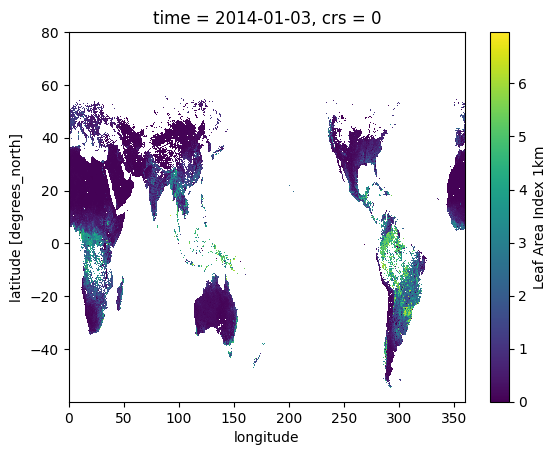

In [24]:
lai[0,:].plot()

We define the template for reprojection and run it!

In [25]:
template = xr.DataArray(
    data=da.zeros(
        (len(lai.time), len(target.latitude), len(target.longitude)),
        chunks=(1, -1, -1),
    ),
    dims=('time', 'latitude', 'longitude'),
    coords={
        'time': lai.time, 
        'latitude': target.latitude, 
        'longitude': target.longitude,
    },
)

In [105]:
def reproject(source):
    # import here, otherwise not seen by workers
    import rioxarray
    from rasterio.warp import reproject, Resampling
    reprojected = source.rio.reproject_match(
        target,
        nodata=np.nan,
        resampling=Resampling.average
    )
    reprojected = reprojected.drop_vars('crs')
    return reprojected.rename(x='longitude', y='latitude')

lai_reprojected = xr.map_blocks(
    reproject,
    lai,
    template=template,
)

We rechunk and save it as Zarr:

In [106]:
lai_reprojected = lai_reprojected.chunk(
    time=-1, 
    longitude=250, 
    latitude=250
)
lai_reprojected = lai_reprojected.to_dataset(name='LAI')

In [107]:
%%time
zarr_path = f'{OUT_DIR}/lai.zarr'
lai_reprojected.to_zarr(zarr_path, mode='w')

CPU times: user 33.5 s, sys: 2.49 s, total: 36 s
Wall time: 2min 2s


When done with the conversion we switch off the cluster to release resources:

In [108]:
client.shutdown()

In [109]:
!du -h $zarr_path

364M	/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/1input_data/2015global/lai/lai.zarr/LAI
2.0K	/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/1input_data/2015global/lai/lai.zarr/longitude
2.0K	/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/1input_data/2015global/lai/lai.zarr/latitude
2.0K	/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/1input_data/2015global/lai/lai.zarr/time
364M	/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/1input_data/2015global/lai/lai.zarr


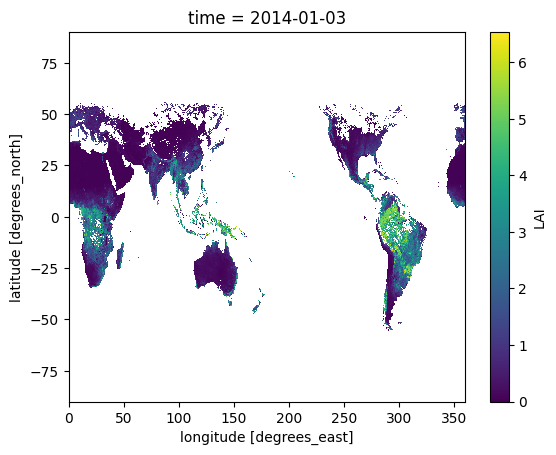

In [32]:
xr.open_zarr(f'{OUT_DIR}/lai.zarr').LAI[0].plot()